In [116]:
import datetime
import io
from collections import defaultdict, OrderedDict

import matplotlib.pyplot as plt
import numpy as np

from gridfs import GridFS
from bson import ObjectId
from PIL import Image
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances


In [117]:
# from virasana.db import mongodb
from pymongo import MongoClient

# from ajna_commons.flask.conf import DATABASE, MONGODB_URI

MONGODB_URI = 'localhost'
DATABASE = 'test'

conn = MongoClient(host=MONGODB_URI)
mongodb = conn[DATABASE]

In [118]:
# from ajna_commons.utils.images import mongo_image
def mongo_image(db, image_id, bboxes=False):
    """Lê imagem do Banco MongoDB. Retorna None se ID não encontrado."""
    fs = GridFS(db)
    _id = ObjectId(image_id)
    if fs.exists(_id):
        grid_out = fs.get(_id)
        image = grid_out.read()
        if bboxes:
            predictions = grid_out.metadata.get('predictions')
            if predictions:
                bboxes = [pred.get('bbox') for pred in predictions]
                image = draw_bboxes(image, bboxes)
        return image
    return None


In [259]:
def norm_distance(array, search):
    return np.linalg.norm(array - search)


def euclidean_sum(array, search):
    return euclidean_distances(array, [search]).sum(axis=0)


def cosine_sum(array, search):
    return cosine_distances(array, [search]).sum(axis=0)


def get_distances(indexes, distance_function=cosine_sum):
    size = indexes.shape[0]
    distances = np.zeros((size, 1), dtype=np.float32)
    for ind in range(size):
        linha = indexes[ind, :]
        distances[ind] = distance_function(indexes, linha)
    return distances

def get_zscores(indexes, distance_function=cosine_sum):
    return zscore(get_distances(indexes, distance_function))

def outlier_index(indexes, max_zscores=3, distance_function=cosine_sum):
    zscores = get_zscores(indexes, distance_function)
    return np.where(zscores > max_zscores)[0]

In [288]:
def get_conhecimentos_um_ncm(db, inicio: datetime, fim: datetime) -> set:
    """Consulta apenas contêineres(imagens) com um NCM e retorna seus conhecimentos."""
    result = set()
    query = {'metadata.contentType': 'image/jpeg',
             'metadata.carga.ncm': {'$size': 1},
             'metadata.carga.container.indicadorusoparcial': {'$ne': 's'},
             'metadata.dataescaneamento': {'$gte': inicio, '$lt': fim}
             }
    projection = {'metadata.carga.conhecimento': 1}
    cursor = mongodb['fs.files'].find(query, projection)
    for linha in cursor:
        conhecimentos = linha.get('metadata').get('carga').get('conhecimento')
        if conhecimentos:
            if isinstance(conhecimentos, str):
                conhecimentos = [conhecimentos]
            for conhecimento in conhecimentos:
                tipo = conhecimento.get('tipo')
                if tipo != 'mbl':
                    conhecimento = conhecimento.get('conhecimento')
                    result.add(conhecimento)
    return result

def get_conhecimentos_zscore(db, inicio: datetime, fim: datetime, min_zscore=3) -> set:
    """Consulta apenas contêineres(imagens) com um NCM e retorna seus conhecimentos."""
    result = set()
    query = {'metadata.contentType': 'image/jpeg',
             'metadata.zscore': {'$gte': min_zscore},
             'metadata.dataescaneamento': {'$gte': inicio, '$lt': fim}
             }
    projection = {'metadata.carga.conhecimento': 1}
    cursor = mongodb['fs.files'].find(query, projection)
    for linha in cursor:
        conhecimentos = linha.get('metadata').get('carga').get('conhecimento')
        if conhecimentos:
            if isinstance(conhecimentos, str):
                conhecimentos = [conhecimentos]
            for conhecimento in conhecimentos:
                tipo = conhecimento.get('tipo')
                if tipo != 'mbl':
                    conhecimento = conhecimento.get('conhecimento')
                    result.add(conhecimento)
    return result


def get_indexes_and_ids_conhecimentos(db, conhecimentos: list):
    """Retorna todas as imagens vinculadas à lista de conhecimentos passada
    
    Aqui são necessários dois passos adicionais:
    
    1. Buscar todas as imagens de cada conhecimento, já que o filtro por período de escaneamento
    pode ter excluído alguma
    
    2. Filtrar novamente o NCM único, para garantir que é único para o lote todo, não somente para 
    um contêiner
    
    """
    conhecimentos_ids = defaultdict(list)
    ids_indexes = dict()
    projection = {'_id': 1, 'metadata.predictions': 1, 'metadata.carga.ncm.ncm': 1}
    for conhecimento in conhecimentos:
        query = {'metadata.carga.conhecimento.conhecimento': conhecimento}
        cursor = db['fs.files'].find(query, projection)
        for linha in cursor:
            predictions = linha['metadata'].get('predictions')
            if predictions:
                index = predictions[0].get('index')
            ncms = linha['metadata'].get('carga').get('ncm')
            if index and ncms and len(ncms) == 1:
                conhecimentos_ids[conhecimento].append(linha['_id'])
                ids_indexes[linha['_id']] = {'index': index, 'ncm': ncms[0]['ncm']}
    return conhecimentos_ids, ids_indexes


def get_ids_score_conhecimento_zscore(db, conhecimentos: list):
    """Retorna todas as imagens vinculadas à lista de conhecimentos passada
    
    Aqui é necessário um passo adicional: buscar todas as imagens de cada conhecimento,
    já que o filtro por período de escaneamento pode ter excluído alguma
    
    """
    conhecimentos_idszscore = defaultdict(list)
    ids_zscores = dict()
    projection = {'_id': 1, 'metadata.zscore': 1}
    for conhecimento in conhecimentos:
        query = {'metadata.carga.conhecimento.conhecimento': conhecimento}
        cursor = db['fs.files'].find(query, projection)
        for linha in cursor:
            zscore_dict = {'_id': linha['_id'],
                           'zscore': linha['metadata'].get('zscore')}
            conhecimentos_idszscore[conhecimento].append(zscore_dict)
    return conhecimentos_idszscore


def grava_zcores(db, conhecimentos_ids, ids_indexes):
    for conhecimento, ids in conhecimentos_ids.items():
        indexes = [ids_indexes[_id]['index'] for _id in ids]
        array_indexes = np.array(indexes)
        zscores = get_zscores(array_indexes)
        for ind, _id in enumerate(ids):
            db['fs.files'].update_one(
                {'_id': _id},
                {'$set': {'metadata.zscore': float(zscores[ind])}})

def filtra_anomalias(conhecimentos_ids, ids_indexes):
    conhecimentos_anomalia = {}
    for conhecimento, ids in conhecimentos_ids.items():
        indexes = [ids_indexes[id]['index'] for id in ids]
        array_indexes = np.array(indexes)
        outliers = outlier_index(array_indexes)
        if outliers.shape[0] > 0:
            conhecimentos_anomalia[conhecimento] = outliers
    return conhecimentos_anomalia

def plot_imagens(imagens):
    plt.figure(figsize=(14, 16))
    for ind, imagem in enumerate(imagens, 1):
        img = Image.open(io.BytesIO(imagem))
        plt.subplot(len(imagens), 1, ind)
        plt.imshow(img)


In [240]:
from pymongo import MongoClient

# from ajna_commons.flask.conf import DATABASE, MONGODB_URI

MONGODB_URI = 'localhost'
DATABASE = 'test'

conn = MongoClient(host=MONGODB_URI)
mongodb = conn[DATABASE]


In [241]:
inicio = datetime.datetime(2017, 7, 1)
fim = datetime.datetime(2017, 7, 8)
conhecimentos = get_conhecimentos_um_ncm(mongodb, inicio, fim)
print('Total de conhecimentos do período: %s' % len(conhecimentos))

Total de conhecimentos do período: 1473


In [242]:
conhecimentos_ids, ids_indexes = get_indexes_and_ids(mongodb, conhecimentos)
print('Total de conhecimentos _ids: %s' % len(conhecimentos_ids))

Total de conhecimentos _ids: 1470


In [243]:
teste = conhecimentos_ids['001709023390352']
teste

[ObjectId('5c5309341004b3779c37e002'),
 ObjectId('5c5309281004b3779c37d396'),
 ObjectId('5c5309341004b3779c37e04a'),
 ObjectId('5c53092b1004b3779c37d732'),
 ObjectId('5c53092f1004b3779c37dab2')]

In [244]:
indexes_test = [ids_indexes[id]['index'] for id in teste]

In [245]:
array_indexes = np.array(indexes_test, dtype=np.float32)
print(array_indexes.shape)
print(array_indexes.dtype)

(5, 128)
float32


In [247]:
distances = get_distances(array_indexes)
distances

array([[0.5309938 ],
       [0.54150146],
       [0.5113558 ],
       [0.5172989 ],
       [1.10331   ]], dtype=float32)

In [249]:
zscore(distances)

array([[-0.47482854],
       [-0.429429  ],
       [-0.5596769 ],
       [-0.5339992 ],
       [ 1.9979328 ]], dtype=float32)

In [256]:
zscores = get_zscores(array_indexes)

In [269]:
for ind, _id in enumerate(teste):
    print(_id, float(zscores[ind]))

5c5309341004b3779c37e002 -0.4748285412788391
5c5309281004b3779c37d396 -0.42942899465560913
5c5309341004b3779c37e04a -0.5596768856048584
5c53092b1004b3779c37d732 -0.5339992046356201
5c53092f1004b3779c37dab2 1.9979327917099


In [233]:
outliers = outlier_index(array_indexes)

In [260]:
conhecimentos_anomalia = filtra_anomalias(conhecimentos_ids, ids_indexes)
print('Total de conhecimentos filtrados: %s' % len(conhecimentos_anomalia))

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


Total de conhecimentos filtrados: 4


In [261]:
conhecimentos_anomalia

{'151705129909709': array([9]),
 '151707135408238': array([5]),
 '151707135615535': array([5]),
 '151707136800050': array([25])}

In [271]:
grava_zcores(mongodb, conhecimentos_ids, ids_indexes)

In [292]:
conhecimentos_anomalia_zscore3 = get_conhecimentos_zscore(mongodb, inicio, fim, min_zscore=3)

In [293]:
conhecimentos_anomalia_zscore3

{'151705129909709', '151707135408238', '151707135615535', '151707136800050'}

In [294]:
conhecimentos_idszscore = get_ids_score_conhecimento_zscore(mongodb, conhecimentos_zscore)

In [295]:
teste = conhecimentos_idszscore['151705129909709']
teste

[{'_id': ObjectId('5c530aa81004b377f3dbcf23'), 'zscore': -0.18946720659732819},
 {'_id': ObjectId('5c530aa81004b377f3dbcec7'), 'zscore': -0.4592357575893402},
 {'_id': ObjectId('5c530aa81004b377f3dbce97'), 'zscore': -0.3761913478374481},
 {'_id': ObjectId('5c530aa81004b377f3dbceeb'), 'zscore': -0.05989456549286842},
 {'_id': ObjectId('5c530aa31004b377f3dbc963'), 'zscore': -0.5540246367454529},
 {'_id': ObjectId('5c530aa31004b377f3dbc993'), 'zscore': 0.12268942594528198},
 {'_id': ObjectId('5c530aa21004b377f3dbc803'), 'zscore': -0.3443857431411743},
 {'_id': ObjectId('5c530aa41004b377f3dbc9e3'), 'zscore': -0.35821157693862915},
 {'_id': ObjectId('5c530aa41004b377f3dbca43'), 'zscore': -0.4431306719779968},
 {'_id': ObjectId('5c530aaf1004b377f3dbd623'), 'zscore': 3.261601686477661},
 {'_id': ObjectId('5c530aa21004b377f3dbc81f'), 'zscore': -0.4115067720413208},
 {'_id': ObjectId('5c530aa31004b377f3dbc8e7'), 'zscore': -0.1882428526878357}]

In [284]:
ids_zscores[ObjectId('5c530aa81004b377f3dbcf23')]

-0.18946720659732819

In [278]:
conhecimentos_zscore2 = get_conhecimentos_zscore(mongodb, inicio, fim, min_zscore=2)
print(len(conhecimentos_zscore2))

386


In [229]:
# Mostra anomalia 
conhecimento = '151705129909709'

ids = conhecimentos_ids[conhecimento]
ind = conhecimentos_anomalia[conhecimento]
ids

[ObjectId('5c530aa81004b377f3dbcf23'),
 ObjectId('5c530aa81004b377f3dbcec7'),
 ObjectId('5c530aa81004b377f3dbce97'),
 ObjectId('5c530aa81004b377f3dbceeb'),
 ObjectId('5c530aa31004b377f3dbc963'),
 ObjectId('5c530aa31004b377f3dbc993'),
 ObjectId('5c530aa21004b377f3dbc803'),
 ObjectId('5c530aa41004b377f3dbc9e3'),
 ObjectId('5c530aa41004b377f3dbca43'),
 ObjectId('5c530aaf1004b377f3dbd623'),
 ObjectId('5c530aa21004b377f3dbc81f'),
 ObjectId('5c530aa31004b377f3dbc8e7')]

In [230]:
print(ind)
id = list(ids)[ind[0]]

[9]


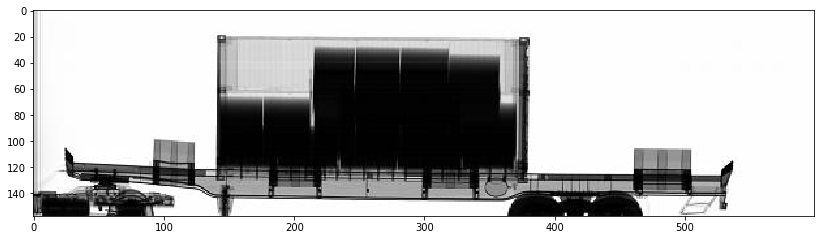

In [231]:
plot_imagens([(mongo_image(mongodb, id))])

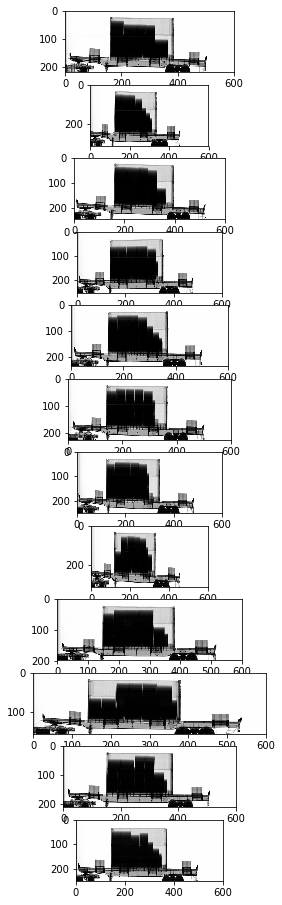

In [232]:
imagens = []
for id in conhecimentos_ids[conhecimento]:
    img = mongo_image(mongodb, ObjectId(id))
    if img:
        imagens.append(img)

# print(imagens)
plot_imagens(imagens)